In [1]:
# ======================================
# ⚙️ 1. Imports
# ======================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [11]:
import pandas as pd

def fix_gotoes_header(filepath):
    """
    Corrige les CSV Garmin exportés avec un header décalé (colonne 'GOTOES_CSV').
    → Décale tous les noms de colonnes d’un cran vers la gauche.
    """
    # Lecture brute du CSV
    df = pd.read_csv(filepath, header=0)
    
    # Vérifie si le premier header est 'GOTOES_CSV'
    if df.columns[0] == 'GOTOES_CSV':
        print(f"⚙️ Correction du header 'GOTOES_CSV' dans {filepath.split('\\')[-1]}")

        # Décale les noms de colonnes d’un cran vers la gauche
        new_cols = df.columns[1:].tolist() + ['extra_col']
        df.columns = new_cols
    
    return df

# Charger un seul fichier corrigé
marathon1 = fix_gotoes_header(r"C:\Users\mathi\OneDrive\Bureau\Machine Learning for time series\marathon_1.csv")
marathon2 = fix_gotoes_header(r"C:\Users\mathi\OneDrive\Bureau\Machine Learning for time series\marathon_2.csv")
semi1 = fix_gotoes_header(r"C:\Users\mathi\OneDrive\Bureau\Machine Learning for time series\semi_1.csv")
semi2 = fix_gotoes_header(r"C:\Users\mathi\OneDrive\Bureau\Machine Learning for time series\semi_2.csv")
semi3 = fix_gotoes_header(r"C:\Users\mathi\OneDrive\Bureau\Machine Learning for time series\semi_3.csv")
dix1 = fix_gotoes_header(r"C:\Users\mathi\OneDrive\Bureau\Machine Learning for time series\10k_1.csv")
dix2 = fix_gotoes_header(r"C:\Users\mathi\OneDrive\Bureau\Machine Learning for time series\10k_2.csv")
# Vérifie le résultat
print("✅ Nouvelles colonnes :", marathon1.columns[:10].tolist())


# ======================================
# ⚙️ 1. Préparation et vérification des données
# ======================================
def prepare_course(df, course_name):
    """
    Nettoie et prépare les données Garmin avec les bonnes unités :
      - Supprime les lignes invalides
      - Convertit les colonnes en unités cohérentes
      - Filtre les valeurs aberrantes
    """
    # Colonnes attendues
    cols = ['distance', 'stance_time', 'vertical_oscillation', 'step_length',
            'enhanced_speed', 'heart_rate', 'enhanced_altitude', 'timestamp',
            'cadence', 'distance', 'speed','altitude', 'power', 'enhanced_altitude', 'vertical_ratio']

    # Vérification de la présence des colonnes
    missing = [c for c in cols if c not in df.columns]
    if missing:
        raise ValueError(f"❌ Colonnes manquantes dans {course_name}: {missing}")

    # Copie et sélection des colonnes
    df = df[cols].copy()

    # ✅ Suppression des valeurs aberrantes sur le temps de contact au sol
    df = df[df['stance_time'] <= 1500]

    # ✅ Conversion des unités (corrigé selon tes précisions)
    # vertical_oscillation : divisé par 10 → passe en centimètres
    df['vertical_oscillation'] = df['vertical_oscillation'] / 10.0

    # step_length : divisé par 1000 → passe en mètres
    df['step_length'] = df['step_length'] / 1000.0

    # ✅ Suppression des vitesses nulles ou aberrantes
    df = df[df['enhanced_speed'] > 0]

    # Affichage optionnel pour suivi
    print(f"✅ {course_name} : {len(df)} lignes valides après nettoyage")

    return df


# Exemple de préparation sur une course
marathon1_clean = prepare_course(marathon1, "Marathon 1")
marathon2_clean = prepare_course(marathon2, "Marathon 2")
semi1_clean = prepare_course(semi1, "Semi 1")
semi2_clean = prepare_course(semi2, "Semi 2")
semi3_clean = prepare_course(semi3, "Semi 3")
dix1_clean = prepare_course(dix1, "10k 1")
dix2_clean = prepare_course(dix2, "10k 2")

# ======================================
# 🧹 4. Nettoyage des données
# ======================================

print("🔍 DIAGNOSTIC DU NETTOYAGE:")
print(f"  Données de départ: {len(marathon1_clean)} lignes")
target_col = 'enhanced_speed'

# Convertir en numérique
marathon1_clean[target_col] = pd.to_numeric(marathon1_clean[target_col], errors='coerce')
print(f"  Après conversion numérique: {marathon1_clean[target_col].notna().sum()} valeurs non-nulles")

# Vérifier la présence de timestamp
if 'timestamp' in marathon1_clean.columns:
    print(f"  Colonne 'timestamp' présente: {marathon1_clean['timestamp'].notna().sum()} valeurs non-nulles")
    print(f"  Exemple de valeur timestamp: {marathon1_clean['timestamp'].iloc[0]}")
else:
    print(f"  ❌ Colonne 'timestamp' ABSENTE!")

print(f"\n✅ Nettoyage effectué:")
print(f"  - Lignes avant: {len(marathon1_clean)}")
print(f"  - Lignes après: {len(marathon1_clean)}")
print(f"  - Lignes supprimées: {len(marathon1_clean) - len(marathon1_clean)}")

# Créer une série temporelle avec index
if 'timestamp' in marathon1_clean.columns:
    print(f"\n🔍 Création de l'index temporel avec 'timestamp'...")
    
    # Sélectionner les colonnes
    ts_data = marathon1_clean[['timestamp', target_col]].copy()
    print(f"  Après sélection colonnes: {len(ts_data)} lignes")
    
    # Dropna sur les deux colonnes
    ts_data = ts_data.dropna()
    print(f"  Après dropna initial: {len(ts_data)} lignes")
    
    # Convertir en datetime
    ts_data['timestamp'] = pd.to_datetime(ts_data['timestamp'], errors='coerce')
    print(f"  Après conversion datetime: {ts_data['timestamp'].notna().sum()} timestamps valides")
    
    # Dropna final
    ts_data = ts_data.dropna()
    print(f"  Après dropna final: {len(ts_data)} lignes")
    
    # Mettre en index
    ts_data = ts_data.set_index('timestamp')
    print(f"\n✅ Index temporel basé sur 'timestamp'")
    if len(ts_data) > 0:
        print(f"\n⏱️ Plage temporelle de la série :")
        print(f"  Début : {ts_data.index.min()}")
        print(f"  Fin   : {ts_data.index.max()}")
        print(f"  Durée totale : {ts_data.index.max() - ts_data.index.min()}")

    
elif 'timestamp' in marathon1_clean.columns:
    ts_data = marathon1_clean[['timestamp', target_col]].dropna().copy()
    ts_data['timestamp'] = pd.to_datetime(ts_data['timestamp'], errors='coerce')
    ts_data = ts_data.dropna().set_index('timestamp')
    print(f"\n✅ Index temporel basé sur 'timestamp'")
else:
    ts_data = marathon1_clean[[target_col]].dropna().copy()
    ts_data.index = range(len(ts_data))
    print(f"\n✅ Index temporel numérique créé")

print(f"\n{'='*60}")
print(f"RÉSULTAT FINAL: {len(ts_data)} points valides")
print(f"{'='*60}")

if len(ts_data) > 0:
    print(f"\nPremières valeurs de la série:")
    print(ts_data.head())
    print(f"\nStatistiques descriptives:")
    print(ts_data[target_col].describe())
else:
    print("⚠️ ATTENTION: Aucune donnée valide après nettoyage!")
    print("Vérifiez les étapes de diagnostic ci-dessus.")

⚙️ Correction du header 'GOTOES_CSV' dans marathon_1.csv
⚙️ Correction du header 'GOTOES_CSV' dans marathon_2.csv
⚙️ Correction du header 'GOTOES_CSV' dans semi_1.csv
⚙️ Correction du header 'GOTOES_CSV' dans semi_2.csv
⚙️ Correction du header 'GOTOES_CSV' dans semi_3.csv
⚙️ Correction du header 'GOTOES_CSV' dans 10k_1.csv
⚙️ Correction du header 'GOTOES_CSV' dans 10k_2.csv
✅ Nouvelles colonnes : ['timestamp', 'position_lat', 'position_long', 'altitude', 'heart_rate', 'cadence', 'distance', 'speed', 'power', 'compressed_speed_distance']
✅ Marathon 1 : 12131 lignes valides après nettoyage
✅ Marathon 2 : 11408 lignes valides après nettoyage
✅ Semi 1 : 5635 lignes valides après nettoyage
✅ Semi 2 : 5636 lignes valides après nettoyage
✅ Semi 3 : 5187 lignes valides après nettoyage
✅ 10k 1 : 3022 lignes valides après nettoyage
✅ 10k 2 : 2732 lignes valides après nettoyage
🔍 DIAGNOSTIC DU NETTOYAGE:
  Données de départ: 12131 lignes
  Après conversion numérique: 12131 valeurs non-nulles
  Co

In [19]:
def prepare_for_forecast(df, course_name):
    """
    Nettoie et prépare les données pour le forecast.
    Assure : pas de NaN, index temporel continu.
    """
    df = df.copy()

    # Vérifie timestamp et vitesse
    if 'timestamp' not in df.columns or 'enhanced_speed' not in df.columns:
        raise ValueError(f"❌ Colonnes manquantes dans {course_name}")

    # Conversion du timestamp
    df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')

    # Sélection et nettoyage
    df = df[['timestamp', 'enhanced_speed']].dropna(subset=['timestamp'])
    df = df[df['enhanced_speed'] > 0]
    df = df[df['enhanced_speed'] < 30]  # filtre anti-valeurs aberrantes
    df = df.sort_values('timestamp').set_index('timestamp')

    # Fréquence régulière + interpolation
    df = df.asfreq('1S')
    df['enhanced_speed'] = df['enhanced_speed'].interpolate(method='time')

    # Dernière vérification NaN
    if df['enhanced_speed'].isna().any():
        df = df.fillna(method='ffill').fillna(method='bfill')

    print(f"✅ {course_name}: {len(df)} points valides (pas de NaN)")
    return df[['enhanced_speed']]


In [20]:
def resample_speed(df, freq='1S'):
    """
    Agrège la vitesse selon la fréquence choisie :
    '1S' = seconde, '1T' = minute, '1K' = km (approx via distance)
    """
    if freq == '1K':
        # Approximation par km (si distance est en km)
        df = df.copy()
        df['km'] = df['distance'].astype(int)
        return df.groupby('km')['enhanced_speed'].mean().to_frame()
    else:
        return df['enhanced_speed'].resample(freq).mean().dropna().to_frame()


In [27]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

def sarima_forecast(df, steps=300):
    """
    Prévision SARIMA robuste — accepte uniquement la série 1D.
    """
    df = df.copy()
    y = df['enhanced_speed']  # série 1D

    # Sécurité anti-NaN
    if y.isna().any():
        raise ValueError(f"⚠️ Données encore NaN : {y.isna().sum()} valeurs")

    model = SARIMAX(y, order=(1, 1, 1), enforce_stationarity=False, enforce_invertibility=False)
    sarima_fit = model.fit(disp=False)

    forecast = sarima_fit.forecast(steps=steps)

    forecast_index = pd.date_range(start=y.index[-1], periods=steps + 1, freq='1S')[1:]
    forecast_df = pd.DataFrame(forecast, index=forecast_index, columns=['forecast'])

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(y.index[-600:], y[-600:], label='Vitesse réelle', color='steelblue')
    plt.plot(forecast_df.index, forecast_df['forecast'], label='Prévision SARIMA', color='orangered')
    plt.title("Prévision SARIMA — Vitesse (km/h)")
    plt.xlabel("Temps")
    plt.ylabel("Vitesse (km/h)")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    return forecast_df


In [28]:
def lstm_forecast(df, lookback=30, steps=300):
    y = df['enhanced_speed'].values.reshape(-1, 1)

    if np.isnan(y).any():
        raise ValueError("⚠️ Données NaN détectées dans enhanced_speed avant LSTM")

    scaler = MinMaxScaler()
    y_scaled = scaler.fit_transform(y)

    gen = TimeseriesGenerator(y_scaled, y_scaled, length=lookback, batch_size=32)

    model = Sequential([
        LSTM(64, activation='tanh', input_shape=(lookback, 1)),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(gen, epochs=15, verbose=0)

    preds = []
    last_seq = y_scaled[-lookback:]
    curr_seq = last_seq.reshape(1, lookback, 1)
    for _ in range(steps):
        pred = model.predict(curr_seq, verbose=0)
        preds.append(pred[0, 0])
        curr_seq = np.append(curr_seq[:, 1:, :], [[[pred[0, 0]]]], axis=1)

    forecast = scaler.inverse_transform(np.array(preds).reshape(-1, 1))
    forecast_index = pd.date_range(start=df.index[-1], periods=steps + 1, freq='1S')[1:]
    forecast_df = pd.DataFrame(forecast, index=forecast_index, columns=['forecast'])

    plt.figure(figsize=(12, 6))
    plt.plot(df.index[-600:], y[-600:], label='Réel', color='steelblue')
    plt.plot(forecast_df.index, forecast_df['forecast'], label='Prévision LSTM', color='darkorange')
    plt.title("Prévision LSTM — Vitesse (km/h)")
    plt.xlabel("Temps")
    plt.ylabel("Vitesse (km/h)")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    return forecast_df


In [29]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def compare_models(df):
    """
    Compare les performances de SARIMA et LSTM.
    Corrige les problèmes de longueur et d'index.
    """
    sarima_pred = sarima_forecast(df, steps=300)
    lstm_pred = lstm_forecast(df, lookback=30, steps=300)

    # Aligner sur la même période temporelle
    common_index = sarima_pred.index.intersection(lstm_pred.index)
    sarima_series = sarima_pred.loc[common_index, 'forecast']
    lstm_series = lstm_pred.loc[common_index, 'forecast']

    if len(common_index) == 0:
        raise ValueError("Les prévisions n'ont aucun index temporel commun.")

    mse_sarima = mean_squared_error(sarima_series, lstm_series)
    mae_sarima = mean_absolute_error(sarima_series, lstm_series)

    print(f"📊 Comparaison sur {len(common_index)} points :")
    print(f"  - MSE : {mse_sarima:.4f}")
    print(f"  - MAE : {mae_sarima:.4f}")

    plt.figure(figsize=(12, 6))
    plt.plot(common_index, sarima_series, label='SARIMA', color='orangered')
    plt.plot(common_index, lstm_series, label='LSTM', color='darkorange', linestyle='--')
    plt.title("Comparaison des prévisions SARIMA vs LSTM")
    plt.xlabel("Temps")
    plt.ylabel("Vitesse (km/h)")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


In [30]:
def forecast_granularities(df, model='LSTM'):
    granularities = {'Seconde': '1S', 'Minute': '1T', 'Kilomètre': '1K'}
    
    for label, freq in granularities.items():
        print(f"\n===== 🔍 Prédiction à la granularité : {label} =====")
        df_resampled = resample_speed(df, freq=freq)
        if len(df_resampled) < 100:
            print("⚠️ Pas assez de points pour cette granularité.")
            continue

        if model == 'SARIMA':
            sarima_forecast(df_resampled, steps=30)
        else:
            lstm_forecast(df_resampled, lookback=30, steps=30)


C:\Users\mathi\AppData\Local\Temp\ipykernel_18144\3346793297.py:22: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  df = df.asfreq('1S')


✅ Marathon 1: 12229 points valides (pas de NaN)


C:\Users\mathi\AppData\Local\Temp\ipykernel_18144\3820693505.py:19: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  forecast_index = pd.date_range(start=y.index[-1], periods=steps + 1, freq='1S')[1:]


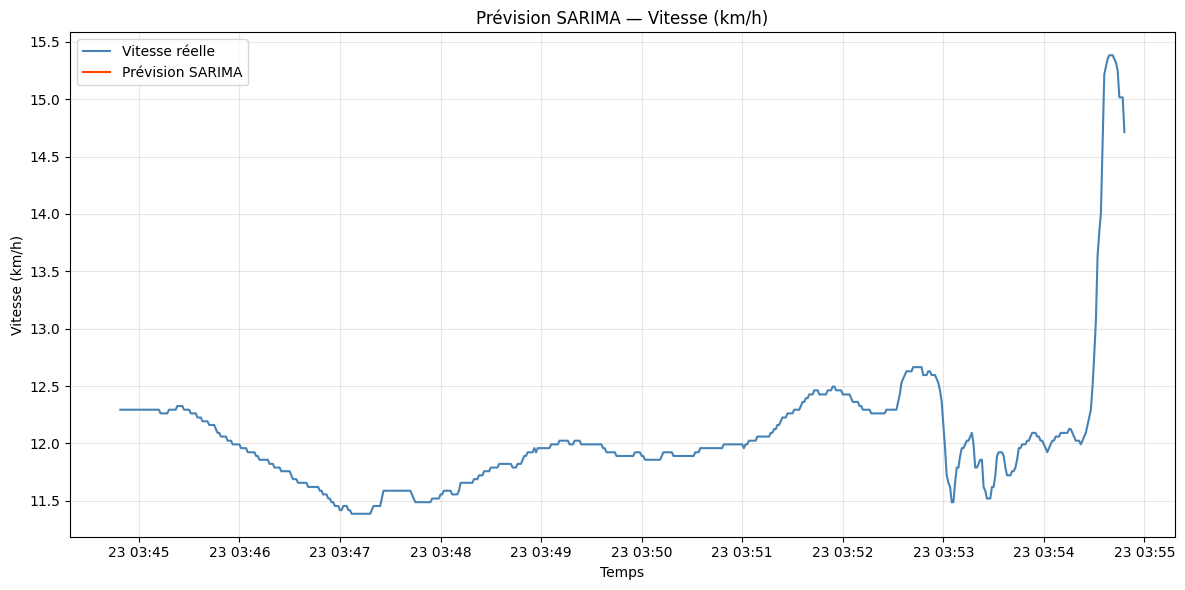

c:\Users\mathi\OneDrive\Bureau\Machine Learning for time series\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\mathi\AppData\Local\Temp\ipykernel_18144\3846221963.py:28: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  forecast_index = pd.date_range(start=df.index[-1], periods=steps + 1, freq='1S')[1:]


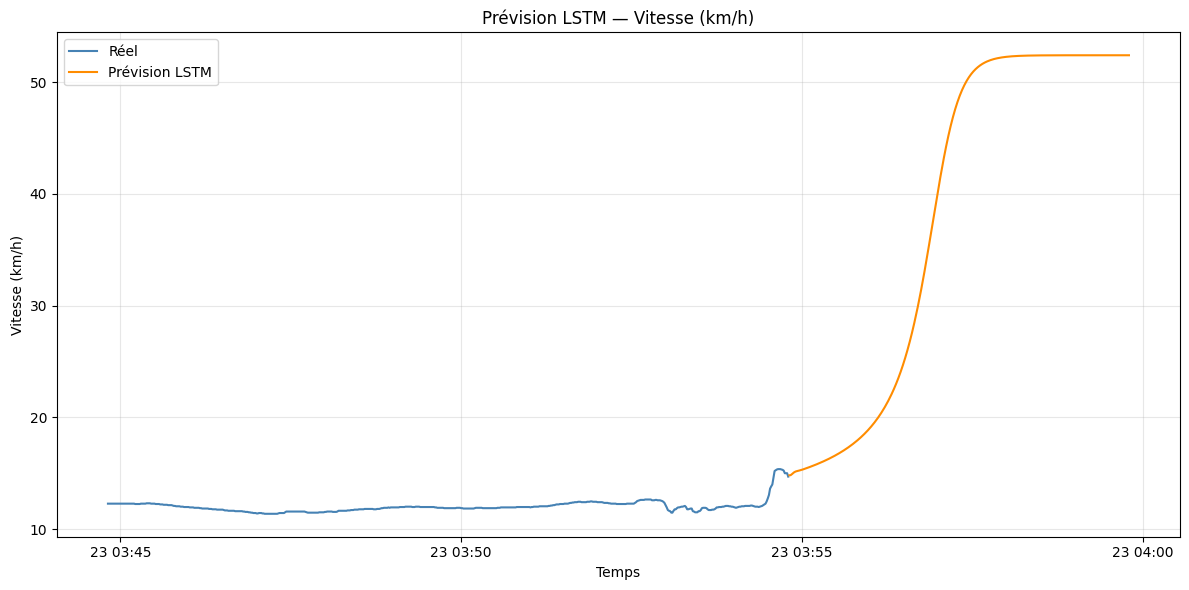

In [31]:
marathon1_prep = prepare_for_forecast(marathon1_clean, "Marathon 1")
sarima_pred = sarima_forecast(marathon1_prep)
lstm_pred = lstm_forecast(marathon1_prep)


In [26]:
marathon1_prep = prepare_for_forecast(marathon1_clean, "Marathon 1")
print("→ Nombre de NaN :", marathon1_prep['enhanced_speed'].isna().sum())
print("→ Index valide ?", isinstance(marathon1_prep.index, pd.DatetimeIndex))
print("→ Timestamps du début :")
print(marathon1_prep.index[:10])
print("→ Timestamps de la fin :")
print(marathon1_prep.index[-10:])


✅ Marathon 1: 12229 points valides (pas de NaN)
→ Nombre de NaN : 0
→ Index valide ? True
→ Timestamps du début :
DatetimeIndex(['2024-11-23 00:31:00', '2024-11-23 00:31:01',
               '2024-11-23 00:31:02', '2024-11-23 00:31:03',
               '2024-11-23 00:31:04', '2024-11-23 00:31:05',
               '2024-11-23 00:31:06', '2024-11-23 00:31:07',
               '2024-11-23 00:31:08', '2024-11-23 00:31:09'],
              dtype='datetime64[ns]', name='timestamp', freq='s')
→ Timestamps de la fin :
DatetimeIndex(['2024-11-23 03:54:39', '2024-11-23 03:54:40',
               '2024-11-23 03:54:41', '2024-11-23 03:54:42',
               '2024-11-23 03:54:43', '2024-11-23 03:54:44',
               '2024-11-23 03:54:45', '2024-11-23 03:54:46',
               '2024-11-23 03:54:47', '2024-11-23 03:54:48'],
              dtype='datetime64[ns]', name='timestamp', freq='s')


C:\Users\mathi\AppData\Local\Temp\ipykernel_18144\3346793297.py:22: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  df = df.asfreq('1S')


C:\Users\mathi\AppData\Local\Temp\ipykernel_18144\3346793297.py:22: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  df = df.asfreq('1S')
C:\Users\mathi\AppData\Local\Temp\ipykernel_18144\588497845.py:13: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  df = df.asfreq('1S')  # fréquence régulière 1 seconde


✅ Marathon 1: 12229 points valides (pas de NaN)


C:\Users\mathi\AppData\Local\Temp\ipykernel_18144\588497845.py:22: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  forecast_index = pd.date_range(start=df.index[-1], periods=steps + 1, freq='1S')[1:]


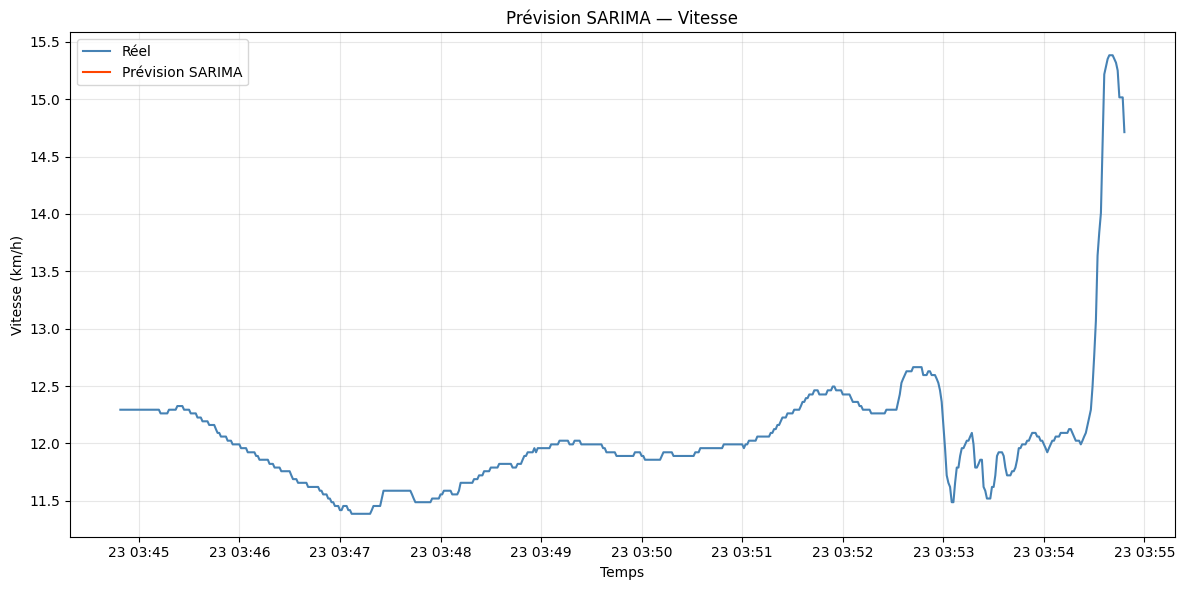

C:\Users\mathi\AppData\Local\Temp\ipykernel_18144\2856614758.py:10: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  df = df.asfreq('1S')
c:\Users\mathi\OneDrive\Bureau\Machine Learning for time series\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\mathi\AppData\Local\Temp\ipykernel_18144\2856614758.py:38: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  forecast_index = pd.date_range(start=df.index[-1], periods=steps + 1, freq='1S')[1:]


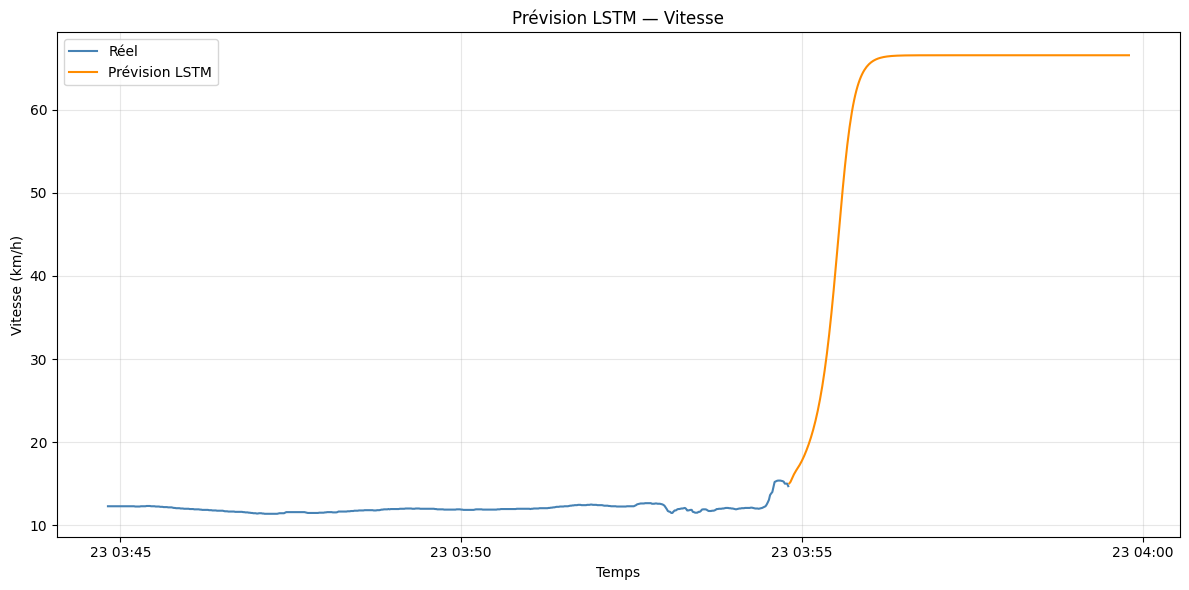

ValueError: Input contains NaN.

In [25]:
marathon1_prep = prepare_for_forecast(marathon1_clean, "Marathon 1")
compare_models(marathon1_prep)

✅ Marathon 1 : 12131 points valides


C:\Users\mathi\AppData\Local\Temp\ipykernel_18144\588497845.py:13: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  df = df.asfreq('1S')  # fréquence régulière 1 seconde
C:\Users\mathi\AppData\Local\Temp\ipykernel_18144\588497845.py:22: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  forecast_index = pd.date_range(start=df.index[-1], periods=steps + 1, freq='1S')[1:]


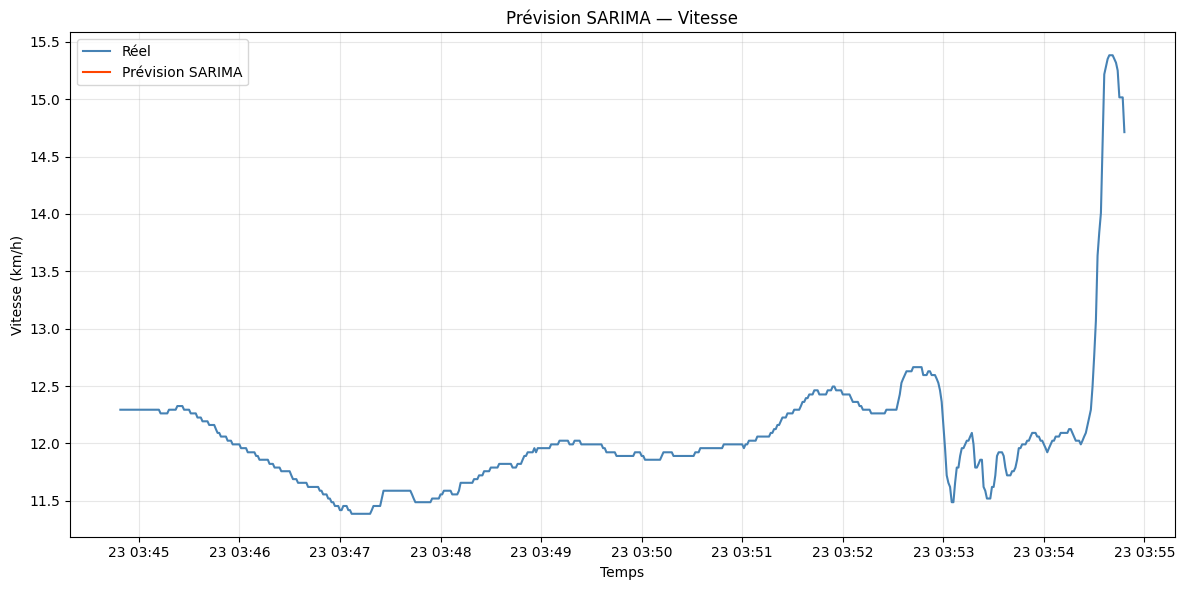

C:\Users\mathi\AppData\Local\Temp\ipykernel_18144\2856614758.py:10: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  df = df.asfreq('1S')
c:\Users\mathi\OneDrive\Bureau\Machine Learning for time series\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\mathi\AppData\Local\Temp\ipykernel_18144\2856614758.py:38: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  forecast_index = pd.date_range(start=df.index[-1], periods=steps + 1, freq='1S')[1:]


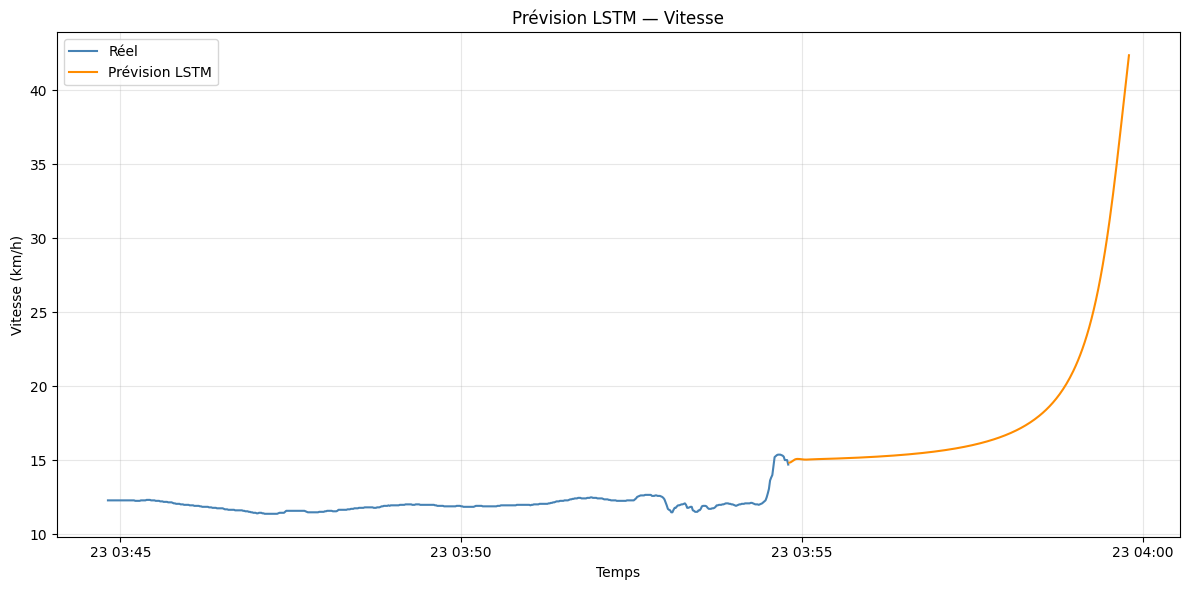

ValueError: Input contains NaN.

In [18]:
marathon1_prep = prepare_for_forecast(marathon1_clean, "Marathon 1")
compare_models(marathon1_prep)


✅ Marathon 1 : 12131 points valides
⚙️ Modèle SARIMA(1,1,1) en exécution...


c:\Users\mathi\OneDrive\Bureau\Machine Learning for time series\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\mathi\OneDrive\Bureau\Machine Learning for time series\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\mathi\OneDrive\Bureau\Machine Learning for time series\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\mathi\OneDrive\Bureau\Machine Learning for time series\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:

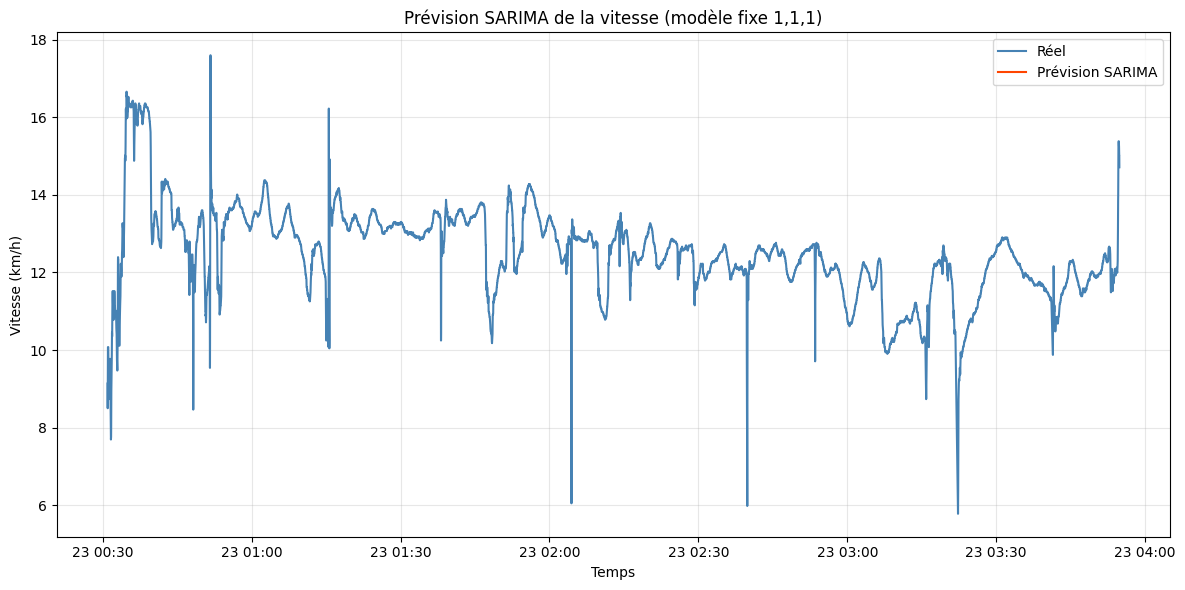

c:\Users\mathi\OneDrive\Bureau\Machine Learning for time series\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\mathi\AppData\Local\Temp\ipykernel_18144\1990677978.py:30: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  forecast_index = pd.date_range(start=df.index[-1], periods=steps + 1, freq='1S')[1:]


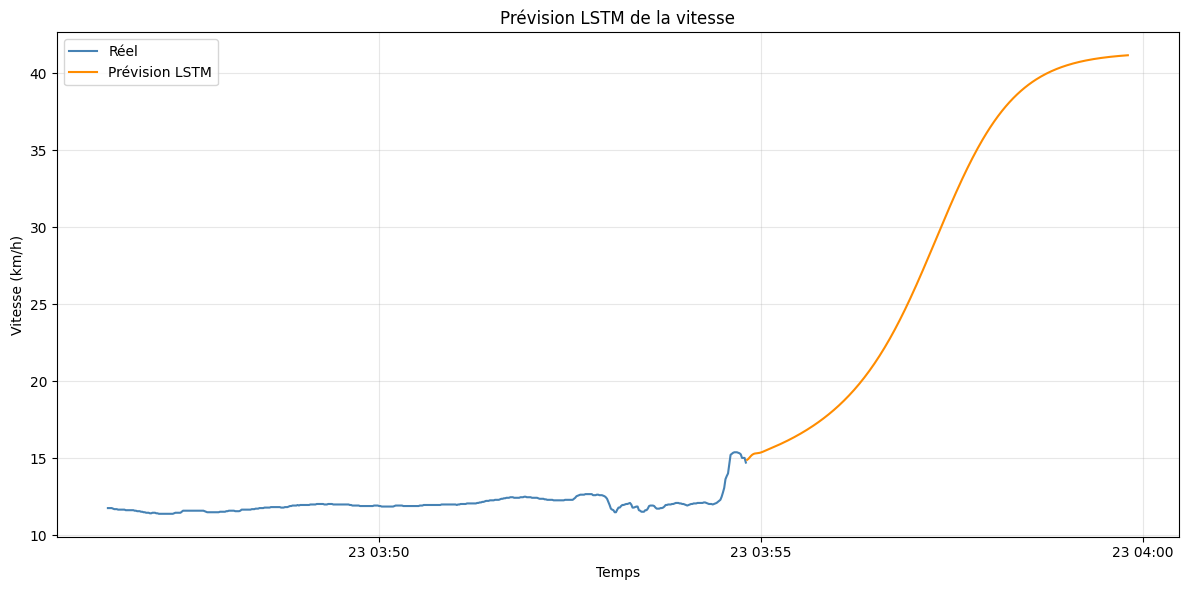

ValueError: Length mismatch: Expected 0 rows, received array of length 300

In [9]:
# Exemple sur une course (Marathon 1)
marathon1_prep = prepare_for_forecast(marathon1_clean, "Marathon 1")

# Comparaison directe des deux modèles
compare_models(marathon1_prep)

# Application du meilleur modèle (disons LSTM) sur les 3 granularités
forecast_granularities(marathon1_prep, model='LSTM')


✅ Dix 1 : 3022 points valides
⚙️ Modèle SARIMA(1,1,1) en exécution...


c:\Users\mathi\OneDrive\Bureau\Machine Learning for time series\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\mathi\OneDrive\Bureau\Machine Learning for time series\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\mathi\OneDrive\Bureau\Machine Learning for time series\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\mathi\OneDrive\Bureau\Machine Learning for time series\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:

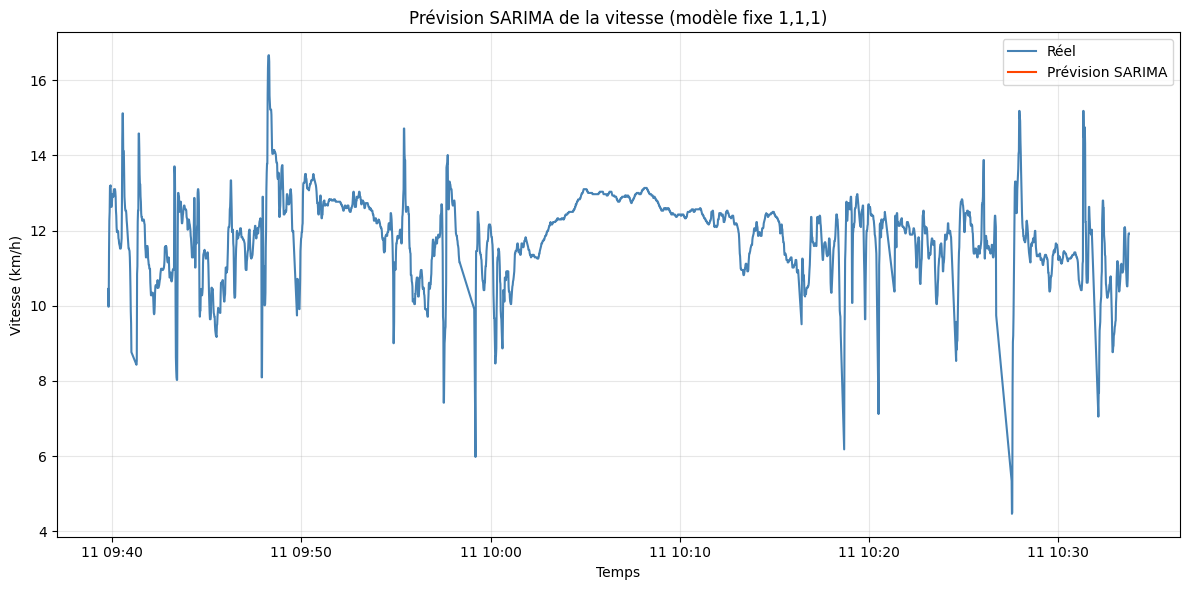

c:\Users\mathi\OneDrive\Bureau\Machine Learning for time series\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\mathi\AppData\Local\Temp\ipykernel_18144\1990677978.py:30: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  forecast_index = pd.date_range(start=df.index[-1], periods=steps + 1, freq='1S')[1:]


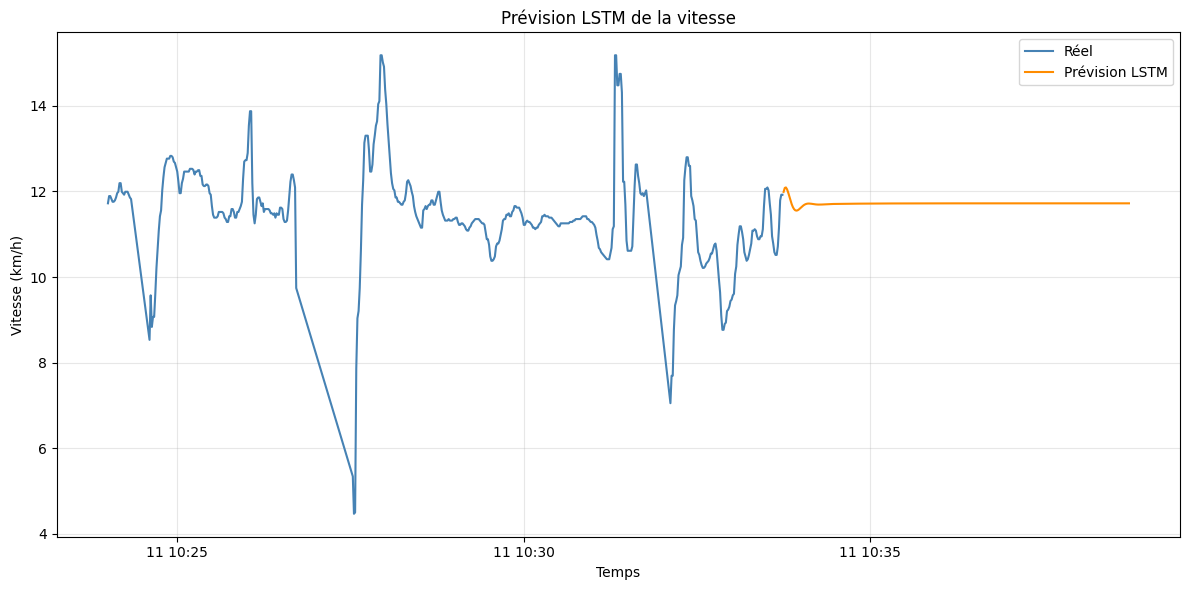

ValueError: Length mismatch: Expected 0 rows, received array of length 300

In [10]:
# Exemple sur une course (Marathon 1)
dix1_clean_prep = prepare_for_forecast(dix1_clean, "Dix 1")

# Comparaison directe des deux modèles
compare_models(dix1_clean_prep)

# Application du meilleur modèle (disons LSTM) sur les 3 granularités
forecast_granularities(dix1_clean_prep, model='LSTM')
